In [1]:
from __future__ import division
import numpy as np
import sys
from sklearn.decomposition import PCA
import math
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import logistic
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [2]:
# read in metadata
metadata = pd.read_csv("data/Integratedpbmc_cluster5_metadata.csv",index_col=0)


In [3]:
# read in integrated data
integrated_data = pd.read_csv("data/Integratedpbmc_cluster5_RNA_rawcounts.csv",index_col=0)
# remove 0s
integrated_data = integrated_data + 1
integrated_data_scaled = integrated_data.apply(lambda x: x/x.sum(), axis=1)
# extract clone size
clone_sizes = metadata[['Clone.size']]
clone_sizes = clone_sizes + 1
# add metadata column
integrated_data_scaled = integrated_data_scaled.append(clone_sizes.T)
# now log normalize
integrated_data_scaled_log = integrated_data_scaled.apply(lambda x: np.log(x),axis=1)

In [4]:
# create my y variable I want to predict. 1 means matching. 0 is not matching
isMatching = []
for index, value in metadata['Matching'].items():
    if '_pbmc_matching' in value:
        isMatching.append(1)
    else:
        isMatching.append(0)
isMatching_np = np.array(isMatching)

In [5]:
# now do PCA
pca = PCA(n_components=int(100))
transformed = pca.fit_transform(integrated_data_scaled_log.T)



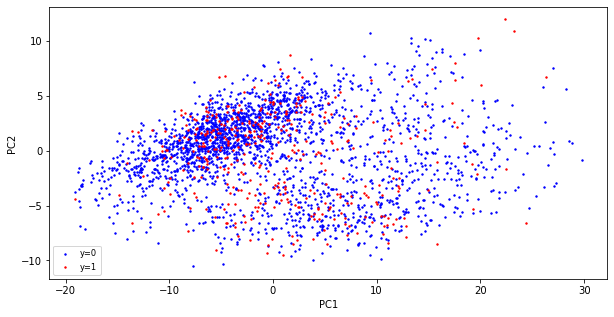

In [6]:
# plot PCA of first 2 PCs and color by matching or non matching
f, axes = plt.subplots(ncols=1, figsize=(10, 5))
axes.scatter(transformed[isMatching_np==0,0], transformed[isMatching_np==0,1], color='blue', s=2, label='y=0')
axes.scatter(transformed[isMatching_np==1,0], transformed[isMatching_np==1,1], color='red', s=2, label='y=1')
axes.set_xlabel('PC1')
axes.set_ylabel('PC2')
axes.legend(loc='lower left', fontsize='small')



Predicted Class,0,1
Actual Class,,
0,380,68
1,25,48


Predicted Class,0,1
Actual Class,,
0,347,91
1,14,68


Predicted Class,0,1
Actual Class,,
0,363,86
1,8,63


Predicted Class,0,1
Actual Class,,
0,360,76
1,15,69


Predicted Class,0,1
Actual Class,,
0,357,74
1,15,74


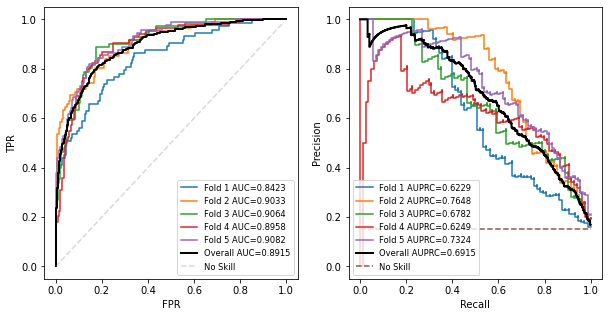

In [7]:
# we are going to do logistic regression to make predictions with a lasso penalty
predictor = LogisticRegression(random_state=0,max_iter=1000,solver='liblinear',penalty="l1",C=.1,class_weight='balanced')
FOLDS = 5
# split data into 5 pieces
k_fold = KFold(n_splits=FOLDS, shuffle=True, random_state=32)
f, axes = plt.subplots(1, 2, figsize=(10, 5))
# store results in these arrays
y_real = []
y_proba = []
y_pred = []
# for each piece
for i, (train_index, test_index) in enumerate(k_fold.split(transformed)):
    # get training and test data
    Xtrain, Xtest = transformed[train_index], transformed[test_index]
    ytrain, ytest = isMatching_np[train_index], isMatching_np[test_index]
    # fit on train data
    predictor.fit(Xtrain, ytrain)
    # get prediction probabilities on test data
    pred_proba = predictor.predict_proba(Xtest)
    # get predictions, matching or non matching
    pred = predictor.predict(Xtest)
    # calculate precision and recall
    precision, recall, _ = precision_recall_curve(ytest, pred_proba[:,1])
    # calculate false positive and true positive rate
    fpr, tpr, _ = roc_curve(ytest, pred_proba[:,1])
    # make labels for plots
    lab = 'Fold %d AUPRC=%.4f' % (i+1, auc(recall, precision))
    lab2 = 'Fold %d AUC=%.4f' % (i+1, roc_auc_score(ytest, pred_proba[:,1]))
    # plot the individual recall-precision and AUC curves for each K fold
    axes[1].step(recall, precision, label=lab)
    axes[0].step(fpr, tpr, label=lab2)
    y_real.append(ytest)
    y_proba.append(pred_proba[:,1])
    y_pred.append(pred)
    # output confusion matrix that shows the predicted class and the actual class to see what we got right and wrong
    confusion_mat = pd.crosstab(
    ytest.flatten(), 
    pred.flatten(), 
    rownames=['Actual Class'], 
    colnames=['Predicted Class'],
    )
    display(confusion_mat)



y_real = np.concatenate(y_real) 
y_proba = np.concatenate(y_proba)
y_pred = np.concatenate(y_pred)
# get overall precision and recall
precision, recall, _ = precision_recall_curve(y_real, y_proba)
# get overall false and true positive rates
fpr, tpr, _ = roc_curve(y_real, y_proba)
lab = 'Overall AUPRC=%.4f' % (auc(recall, precision))
lab2 = 'Overall AUC=%.4f' % (roc_auc_score(y_real, y_proba))
# plot overall precision recall curve
axes[1].step(recall, precision, lw=2,label=lab, color='black')
# make a dotted line illustrating what would happen if our ML algorithm had no skill
no_skill = len(y_real[y_real==1]) / len(y_real)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend(loc='lower left', fontsize='small')
# now plot overall AUC curve
axes[0].step(fpr, tpr, label=lab2, lw=2, color='black')
dotted_line_coords=np.arange(0,100)/100
axes[0].plot(dotted_line_coords,dotted_line_coords,'--',color="gray",alpha=0.3,label='No Skill')
axes[0].set_xlabel('FPR')
axes[0].set_ylabel('TPR')
axes[0].legend(loc='lower right', fontsize='small')




In [8]:
f.tight_layout()
output_pdf = "cluster_5_PCA_ML_res.pdf"
f.savefig(output_pdf)


In [9]:
# do a version where we use all our data and use the best l1 penalty from cross validation. not used in manuscript
X_train, X_test, y_train, y_test = train_test_split(transformed, isMatching_np, test_size=0.30, random_state=42)

model2 = LogisticRegressionCV(cv=3, random_state=0,penalty='l1',Cs=[1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4],solver='liblinear').fit(X_train, y_train)

0.9054945054945055
0.9039692701664532
[0.1]


Predicted Class,0,1
Actual Class,,
0,651,8
1,67,55


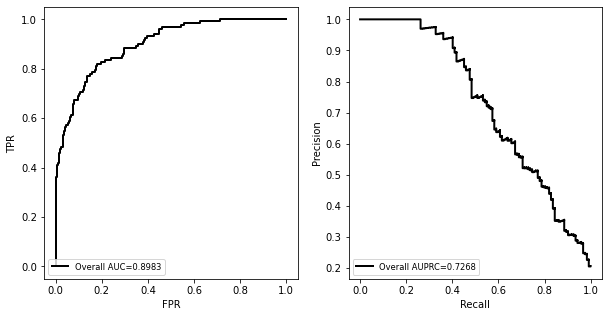

In [10]:
# extract accuracy of model
model2_score_train = model2.score(X_train, y_train)
model2_score_test = model2.score(X_test, y_test)
# get predictions
y_pred = model2.predict(X_test)
print(model2_score_train)
print(model2_score_test)
# print out the best penalty
print(model2.C_)
# output confusion matrix
confusion_mat = pd.crosstab(
    y_test.flatten(), 
    y_pred.flatten(), 
    rownames=['Actual Class'], 
    colnames=['Predicted Class'],
    )
display(confusion_mat)
# get predicted probabilities to make roc curve
pred_proba = model2.predict_proba(X_test)
# calculate precision recall
precision, recall, _ = precision_recall_curve(y_test, pred_proba[:,1])
# calculate true and false positives
fpr, tpr, _ = roc_curve(y_test, pred_proba[:,1])

lab = 'Overall AUPRC=%.4f' % (auc(recall, precision))
lab2 = 'Overall AUC=%.4f' % (roc_auc_score(y_test, pred_proba[:,1]))

# make plots
f, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[1].step(recall, precision, lw=2,label=lab, color='black')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend(loc='lower left', fontsize='small')
axes[0].step(fpr, tpr, label=lab2, lw=2, color='black')
axes[0].set_xlabel('FPR')
axes[0].set_ylabel('TPR')
axes[0].legend(loc='lower left', fontsize='small')



In [12]:
# do random forest to get feature importance
clf = RandomForestClassifier(random_state=0, n_jobs=-1)
# exclude the clone size this time cause we want feature importance of genes only
integrated_data_scaled_log_transformed = integrated_data_scaled_log.T
integrated_data_scaled_log_transformed = integrated_data_scaled_log_transformed.drop(columns=['Clone.size'])
# fit random forest
model = clf.fit(integrated_data_scaled_log_transformed, isMatching_np)

        feature  importance
11975   Trav16n    0.003811
4904     Trbv29    0.003651
7577      Itgb1    0.001828
5958    Gramd1a    0.001698
13942      Ier3    0.001475
5115     Tmsb10    0.001418
4444     Vps37b    0.001372
2417      Rps27    0.001320
4656       Actb    0.001308
15633    Tmsb4x    0.001303
11951  Trav8d-2    0.001281
11391    Ctla2a    0.001252
9885       Ccl5    0.001238
5953      Fxyd5    0.001178
14007  Hsp90ab1    0.001124
11980   Trav7-3    0.001076
14110     Rpl36    0.001022
3530      Rpl11    0.000974
10622     Rps29    0.000918
8365      Eomes    0.000917


/var/folders/76/q9rw3hvd5b76kvy0p8ymldw00000gn/T/ipykernel_42525/2224648881.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axe.set_xticklabels(importance_names_sorted_top20['feature'],rotation=70)


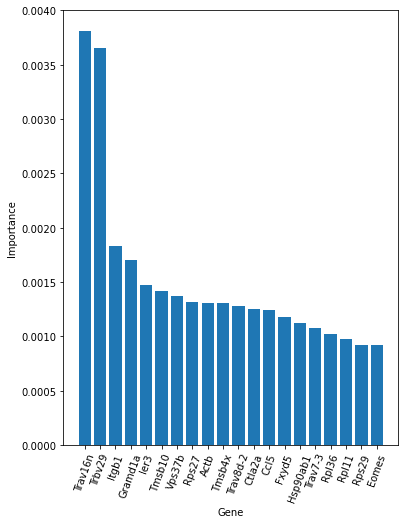

In [43]:
# get feature importance

importances = model.feature_importances_
importance_names = pd.DataFrame({'feature':integrated_data_scaled_log_transformed.columns.values.tolist(),'importance':importances})
# sort matrix by importance
importance_names_sorted = importance_names.sort_values(by=['importance'],ascending=False)
importance_names_sorted_top20 = importance_names_sorted.head(20)
# print top 20 genes
print(importance_names_sorted_top20)
# make feature importance plots.
f, axe = plt.subplots(1, 1, figsize=(6, 8))
axe.bar(importance_names_sorted_top20['feature'], importance_names_sorted_top20['importance'])
axe.set_xlabel("Gene")
axe.set_ylabel("Importance")
axe.set_xticklabels(importance_names_sorted_top20['feature'],rotation=70)
f.savefig('feature_importance.pdf')